# Problem Description

The goal of this project is to use deep learning to classify images.

Dataset:
The data comes from the popular dataset ImageNet. The dataset used in our problem consists of two classes of vehicles, namely 'Sports Car' and 'Trolley'. There are 500 images in each class in the train set, and 50 in the test set.

Approach:
We use three approaches, namely
- Multilayer Perceptrons (MLPs)
- Convolutional Neural Nets (CNNs)
- Specialized architectures such as ResNet and VGG-16.

Framework:
We use PyTorch to build our models

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import torchvision.models as models
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

import os
import time
from IPython.display import Image
from PIL import Image
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Copying files to local path...")
# Copy from Google Drive into Disk
!cp -r '/content/drive/MyDrive/tiny-imagenet-200' '/content/path/'
print("Copying complete.")

Copying files to local path...
Copying complete.


# Data Loader

Here we load the data, preprocess it and create data loaders that will be used later.

In [ ]:
#Image Dimensions
n=64 #64x64 files


# Transform function for datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


data_path = '/content/path/2_class_dataset'
# Preparing train and validation datasets
train_subset = datasets.ImageFolder(root= f'{data_path}/train' , transform=transform)
val_subset = datasets.ImageFolder(root= f'{data_path}/val' , transform=transform)


# Create a DataLoader to batch and shuffle the data
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=100, shuffle=False)

num_classes = len(train_loader.dataset.classes)

class_label_dict = {'n04285008':'Sports Car','n04487081':'Trolley',
                 'n04146614':'School Bus','n03977966': 'Police Van',
                 'n02123045':'Tabby Cat','n02123394': 'Persian Cat',
                 'n02124075':'Egyptian Cat','n02125311':'Cougar',
                 'n02129165':'Lion'}




# Definitions of Model Networks

The MLPs, CNNs, ResNets and VGGs are defined below

In [ ]:
### Simple Neural Nets ###
class OneLayerNN(nn.Module):
    def __init__(self, input_size=3*n*n, l1=100, k=num_classes):
        super(OneLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, l1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(l1, k)
        self.name = 'One Layer NN'
        self.param = f'l1={l1}'

    def forward(self, x):
        x = x.view(-1, 3*n*n)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class TwoLayerNN(nn.Module):
    def __init__(self, input_size=3*n*n, l1=100, l2=20, k=num_classes):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, l1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(l1, l2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(l2, k)
        self.name = 'Two Layer NN'
        self.param = f'l1={l1},l2={l2}'

    def forward(self, x):
        x = x.view(-1, 3*n*n)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

class ThreeLayerNN(nn.Module):
    def __init__(self, input_size=3*n*n, l1=100, l2=50, l3=20, k=num_classes):
        super(ThreeLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, l1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.fc4 = nn.Linear(l3, k)
        self.name = 'Three Layer NN'
        self.param = f'l1={l1},l2={l2},l3={l3}'

    def forward(self, x):
        x = x.view(-1, 3*n*n)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

class FourLayerNN(nn.Module):
    def __init__(self, input_size=3*n*n, l1=100, l2=50, l3=20, l4=10, k=num_classes):
        super(FourLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.fc4 = nn.Linear(l3, l4)
        self.fc5 = nn.Linear(l4, k)
        self.relu = nn.ReLU()
        self.name = 'Four Layer NN'
        self.param = f'l1={l1},l2={l2},l3={l3},l4={l4}'


    def forward(self, x):
        x = x.view(-1, 3*n*n)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

### CNN Model with 2 convolution layers
class TwoLayerCNN(nn.Module):
    def __init__(self, k=num_classes, n1=16, n2=32, f=5, l1=120, l2=84): #
        super(TwoLayerCNN, self).__init__()
        self.n1, self.n2 = n1, n2
        self.conv1 = nn.Conv2d(3, n1, f)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n1, n2, f)
        self.n0 = int((n-3*(f-1))/4)
        self.n2 = n2
        self.fc1 = nn.Linear(n2 * self.n0 * self.n0, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, k)
        self.name = 'Two-Layer CNN'
        self.param = f'n1={n1}, n2={n2}, f={f}, l1={l1}, l2={l2}'


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, self.n2 * self.n0 * self.n0)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### ResNet
class ResNet18(nn.Module):
    def __init__(self, k=num_classes):
        super(ResNet18, self).__init__()
        # Load the pretrained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)

        # Replace the first convolutional layer to adapt to 64x64 RGB images
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer to match the number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, k)

        self.name = 'ResNet18'
        self.param = ''

    def forward(self, x):
        return self.resnet(x)

class ResNet34(nn.Module):
    def __init__(self, k=num_classes):
        super(ResNet34, self).__init__()
        # Load the pretrained ResNet34 model
        self.resnet = models.resnet34(pretrained=True)

        # Replace the first convolutional layer to adapt to 64x64 RGB images
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer to match the number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, k)
        self.name = 'ResNet34'
        self.param = ''

    def forward(self, x):
        return self.resnet(x)

class ResNet50(nn.Module):
    def __init__(self, k=num_classes):
        super(ResNet50, self).__init__()
        # Load the pretrained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)

        # Replace the first convolutional layer to adapt to 64x64 RGB images
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer to match the number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, k)
        self.name = 'ResNet50'
        self.param = ''

    def forward(self, x):
        return self.resnet(x)

class VGG16(nn.Module):
    def __init__(self, k=num_classes):
        super(VGG16, self).__init__()
        # Load a pre-trained VGG16 model
        self.vgg = models.vgg16(pretrained=True)

        # Freeze all layers except the final fully connected layer (classifier)
        for param in self.vgg.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer with a new one for your specific task
        num_features = self.vgg.classifier[0].in_features
        self.vgg.classifier = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, k),
        )
        self.name = 'VGG-16'
        self.param = ''
    def forward(self, x):
        return self.vgg(x)





Below is a function that trains and evaluates models based on the train and test data supplied earlier. It then prints:
- Train and validation losses
- Confusion Matrices
- Classification Report of Precision, Recall, F1 score etc

In [ ]:
# Definition of a training/evaluation run
def run(model_0):
  # Training loop
  num_epochs = 100
  train_losses, val_losses = [], []

  # Initialize variables for early stopping
  best_loss = float('inf')
  best_epoch = 0
  epoch_ctr = 0
  patience = 5  # Number of epochs without improvement before early stopping

  # Send model to GPU
  model = model_0
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  starttime = time.time()
  # Train-Validate Loop
  for epoch in range(num_epochs):
      epoch_ctr += 1
      # Training phase
      model.train()
      running_loss = 0.0
      for images, labels in tqdm(train_loader, desc='Training loop'):
      # for images, labels in train_loader:
          # Move inputs and labels to the device
          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * labels.size(0)
      train_loss = running_loss / len(train_loader.dataset)
      train_losses.append(train_loss)

      # Validation phase
      model.eval()
      running_loss = 0.0
      with torch.no_grad():
          # for images, labels in tqdm(val_loader, desc='Validation loop'): #with progress bar
          for images, labels in val_loader: # without progress bar
              # Move inputs and labels to the device
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)
              running_loss += loss.item() * labels.size(0)
      val_loss = running_loss / len(val_loader.dataset)
      val_losses.append(val_loss)

      # # Check if validation loss has improved
      # if val_loss < best_val_loss:
      #     best_val_loss = val_loss
      #     counter = 0
      # else:
      #     counter += 1

      print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

      # Check for early stopping
      if val_loss < best_loss:
          best_loss = val_loss
          best_epoch = epoch
          torch.save(model.state_dict(), 'best_model.pth')
      elif epoch - best_epoch >= patience:
          print(f'Early stopping at epoch {epoch+1}, using weights of epoch {best_epoch+1}')
          model.load_state_dict(torch.load('best_model.pth'))
          break

  endtime = time.time()

  print(f"Runtime={endtime-starttime}")

  #Plot of Losses
  fig, ax = plt.subplots(figsize=(5,4))
  plt.plot(range(1,epoch_ctr+1), train_losses, label='Train Losses')
  plt.plot(range(1,epoch_ctr+1), val_losses, label='Validation Losses')
  plt.xlabel('Epoch#')
  plt.ylabel('Cross-Entropy Loss')
  plt.title(f'{model.name},{model.param}')
  plt.legend()
  plt.show()
  plt.clf()


  #### Evaluating model accuracy ####
  all_predictions_train, all_labels_train, all_predictions_val, all_labels_val = [], [], [], []
  model.eval()
  with torch.no_grad():

      #Training Set Accuracy
      for images, labels in train_loader:
          # Move inputs and labels to the device
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
          all_predictions_train.extend(predicted.to(float).tolist())
          all_labels_train.extend(labels.to(float).tolist())

      #Validation Set Accuracy
      for images, labels in val_loader:
          # Move inputs and labels to the device
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
          all_predictions_val.extend(predicted.to(float).tolist())
          all_labels_val.extend(labels.to(float).tolist())

  #Display classification accuracies
  #Train set
  preds_and_labels_train = [(all_predictions_train[i], all_labels_train[i]) for i in range(len(all_labels_train))]
  print(f"Number of correctly classified train samples= \
        {sum([p==l for p, l in zip(all_predictions_train, all_labels_train)])}/{len(preds_and_labels_train)}")
  #Val Set
  preds_and_labels_val = [(all_predictions_val[i], all_labels_val[i]) for i in range(len(all_labels_val))]
  print(f"Number of correctly classified validation samples= \
        {sum([p==l for p, l in zip(all_predictions_val, all_labels_val)])}/{len(preds_and_labels_val)}")

  # Compute confusion matrices
  conf_matrix_train = confusion_matrix(all_labels_train, all_predictions_train)
  conf_matrix_val = confusion_matrix(all_labels_val, all_predictions_val)

  # classes = ['Sports Cars', 'Trolleys']
  classes = [class_label_dict[idx] for idx in train_loader.dataset.classes]
  fig, axs = plt.subplots(ncols=2, figsize=(10,4))
  # Visualize confusion matrix
  sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axs[0])
  axs[0].set_xlabel('Predicted Labels')
  axs[0].set_ylabel('True Labels')
  axs[0].set_title('Training Set')
  sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axs[1])
  axs[1].set_xlabel('Predicted Labels')
  axs[1].set_ylabel('True Labels')
  axs[1].set_title('Validation Set')
  fig.suptitle(f'{model.name},{model.param}')
  plt.tight_layout()
  plt.show()


  class_report_train = classification_report(all_labels_train, all_predictions_train, target_names=classes)
  class_report_val = classification_report(all_labels_val, all_predictions_val, target_names=classes)

  confusion_indices = [[[] for _ in range(num_classes)] for _ in range(num_classes)]

  for i in range(len(all_labels_val)):
    (confusion_indices[int(all_labels_val[i])][int(all_predictions_val[i])]).append(i)


  print('Classification Report for Train Set: \n',class_report_train)
  print('Classification Report for Validation Set: \n',class_report_val)

  # Define the size of the grid
  grid_size = 5

  # Initialize a figure and axis object
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))


  print('A sample of one image for each confusion category')
  # Iterate over the first 25 images in the validation loader
  for i in range(grid_size):
      for j in range(grid_size):
          # Get the image and its label from the validation loader
          if len(confusion_indices[i][j])>0:
            image, label = val_loader.dataset[confusion_indices[i][j][0]]

            M=torch.tensor([0.485, 0.456, 0.406])
            S=torch.tensor([0.229, 0.224, 0.225])
            # Convert the PyTorch tensor to a NumPy array and transpose the dimensions
            image = image.permute(1, 2, 0)*S+M

            # Plot the image in the corresponding subplot
            axes[i, j].imshow(image)
            axes[i, j].axis('off')

          # Add label to the x-axis of the bottom row
          if i == grid_size - 1:
              axes[i, j].set_xlabel(classes[j], fontsize=12)

          # Add label to the y-axis of the leftmost column
          if j == 0:
              axes[i, j].set_ylabel(classes[i], fontsize=12)

  # Adjust layout to prevent overlap of subplots
  plt.xlabel(classes)
  plt.ylabel(classes)
  plt.tight_layout()
  plt.show()


  return None

# Architecture Evaluations

## Simple NN

### Single Linear Layer

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.6869917907714844, Validation loss: 0.5582873821258545


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.37060615921020507, Validation loss: 0.4564427435398102


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.2576247915029526, Validation loss: 0.4738098382949829


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.19228361022472382, Validation loss: 0.4442480504512787


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.12952218449115754, Validation loss: 0.3509830832481384


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.08116440246999264, Validation loss: 0.5642419457435608


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.05469339838624, Validation loss: 0.5450682640075684


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.03595463558286428, Validation loss: 0.5172408819198608


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.01790489434823394, Validation loss: 0.5444268584251404


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.011631360642611981, Validation loss: 0.6088202595710754
Early stopping at epoch 10, using weights of epoch 5
Runtime=9.623557090759277


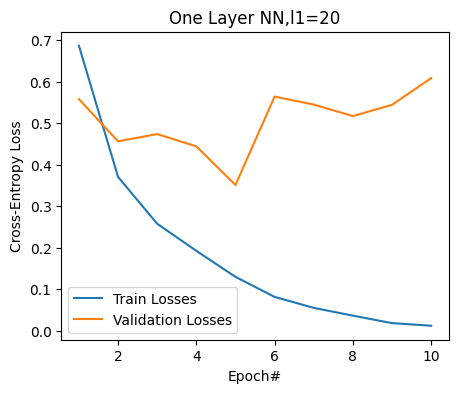

Number of correctly classified train samples=         973/1000
Number of correctly classified validation samples=         81/100


<Figure size 640x480 with 0 Axes>

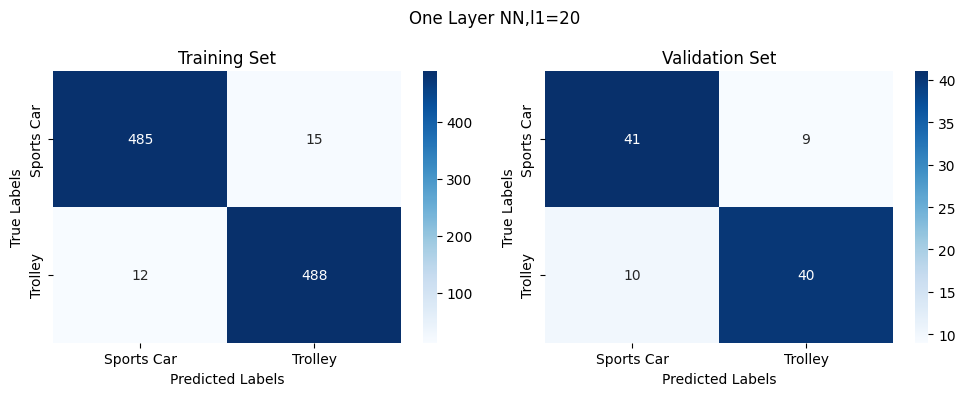

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.98      0.97      0.97       500
     Trolley       0.97      0.98      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.80      0.82      0.81        50
     Trolley       0.82      0.80      0.81        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



In [ ]:
onelayer20 = OneLayerNN(l1=20)
run(onelayer20)

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.9358490346670151, Validation loss: 0.557975172996521


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.3701309287548065, Validation loss: 0.48871004581451416


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.2521779826879501, Validation loss: 0.5743868350982666


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.2610178914070129, Validation loss: 0.7229659557342529


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.1732798434495926, Validation loss: 0.5531942248344421


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.08812295204401016, Validation loss: 0.4259195327758789


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.08197817496210337, Validation loss: 0.6562896966934204


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.09804729425907135, Validation loss: 0.6161243319511414


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.031101159751415253, Validation loss: 0.5111915469169617


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.01862784993648529, Validation loss: 0.49822142720222473


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.011716320268809796, Validation loss: 0.5709304213523865
Early stopping at epoch 11, using weights of epoch 6
Runtime=11.703029870986938


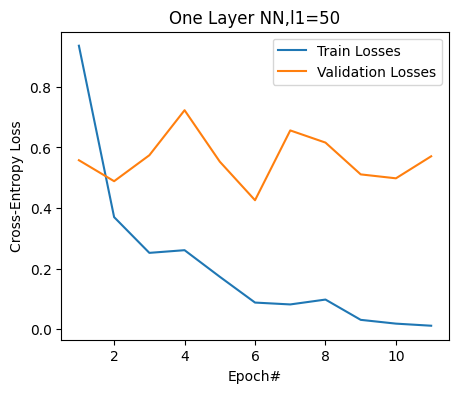

Number of correctly classified train samples=         982/1000
Number of correctly classified validation samples=         84/100


<Figure size 640x480 with 0 Axes>

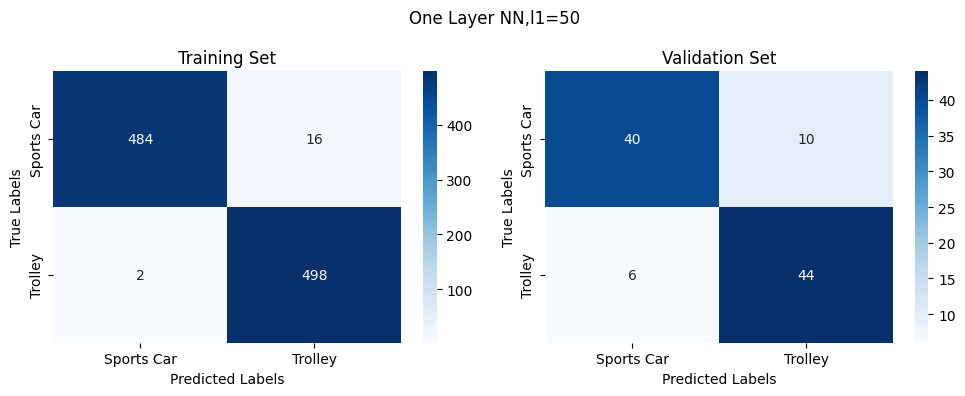

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       1.00      0.97      0.98       500
     Trolley       0.97      1.00      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.87      0.80      0.83        50
     Trolley       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



In [ ]:
onelayer50 = OneLayerNN(l1=50)
run(onelayer50)

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 1.1571035928726197, Validation loss: 0.7802829146385193


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.44766015219688415, Validation loss: 0.6631738543510437


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.30204159224033356, Validation loss: 0.5486798286437988


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.2207626814842224, Validation loss: 0.4343178868293762


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.11448900270462035, Validation loss: 0.400241881608963


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.06990718033164739, Validation loss: 0.30814215540885925


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.0342556149661541, Validation loss: 0.39499932527542114


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.03150704806298017, Validation loss: 0.35799357295036316


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.013874855298257898, Validation loss: 0.3615931272506714


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.007552423171699047, Validation loss: 0.3832067847251892


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.005004427134990692, Validation loss: 0.38964831829071045
Early stopping at epoch 11, using weights of epoch 6
Runtime=15.233754634857178


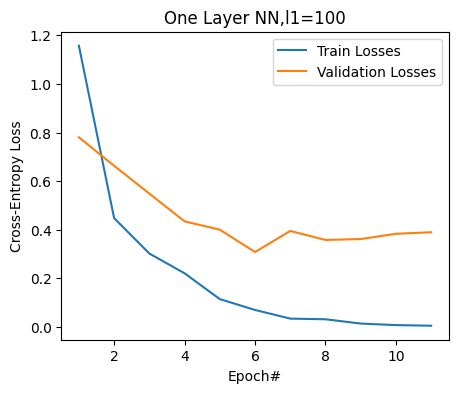

Number of correctly classified train samples=         992/1000
Number of correctly classified validation samples=         83/100


<Figure size 640x480 with 0 Axes>

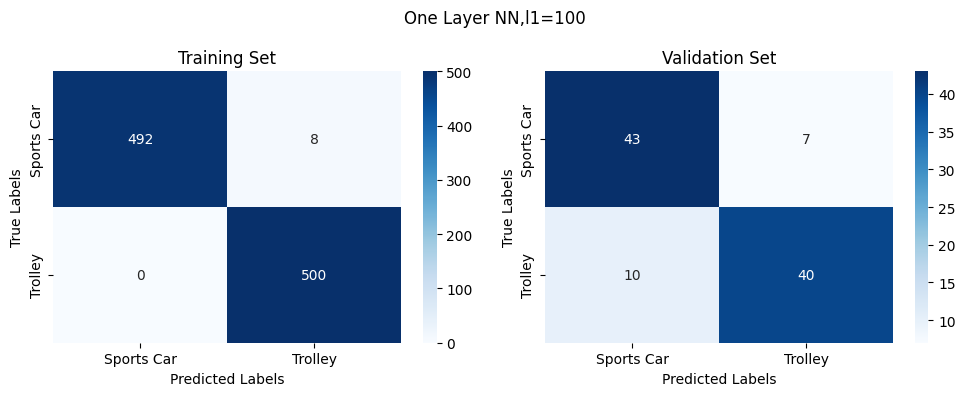

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       1.00      0.98      0.99       500
     Trolley       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.81      0.86      0.83        50
     Trolley       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



In [ ]:
onelayer100 = OneLayerNN(l1=100)
run(onelayer100)

### Two Layers

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.5838670625686645, Validation loss: 0.48534488677978516


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.37605904293060305, Validation loss: 0.4303966462612152


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.2571630370616913, Validation loss: 0.3848007619380951


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.180352820456028, Validation loss: 0.4862481951713562


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.09850534296035766, Validation loss: 0.42269256711006165


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.054433263674378396, Validation loss: 0.4828770160675049


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.04314606630057097, Validation loss: 0.5643541216850281


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.0337553690597415, Validation loss: 0.4875263571739197
Early stopping at epoch 8, using weights of epoch 3
Runtime=21.50317120552063


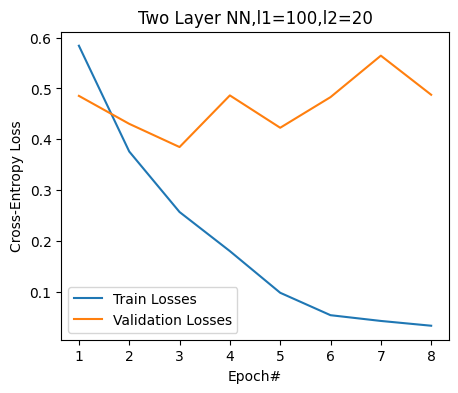

Number of correctly classified train samples=         947/1000
Number of correctly classified validation samples=         84/100


<Figure size 640x480 with 0 Axes>

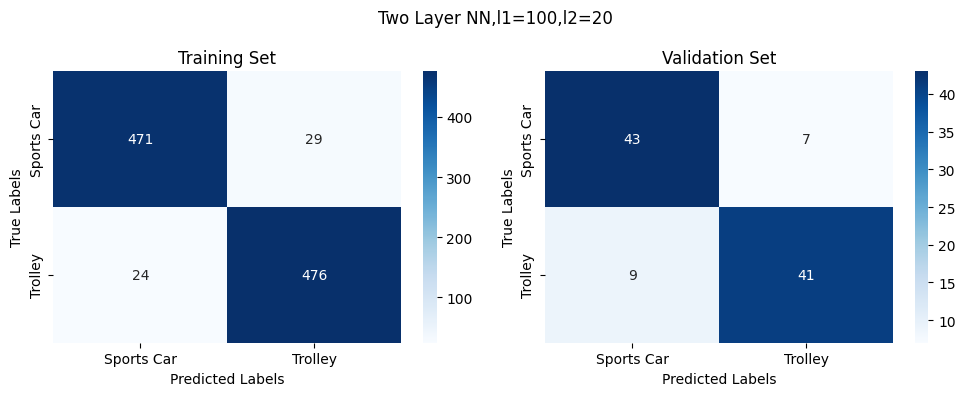

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.95      0.94      0.95       500
     Trolley       0.94      0.95      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.83      0.86      0.84        50
     Trolley       0.85      0.82      0.84        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



In [ ]:
twolayer = TwoLayerNN()
run(twolayer)

### Three Layers

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.5265235409736634, Validation loss: 0.40838608145713806


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.3759384779930115, Validation loss: 0.448808491230011


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.2917923834323883, Validation loss: 0.4961800277233124


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.24112716615200042, Validation loss: 0.4564470648765564


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.1717270702123642, Validation loss: 0.46638667583465576


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.12138466241955757, Validation loss: 0.5317921042442322
Early stopping at epoch 6, using weights of epoch 1
Runtime=8.120023965835571


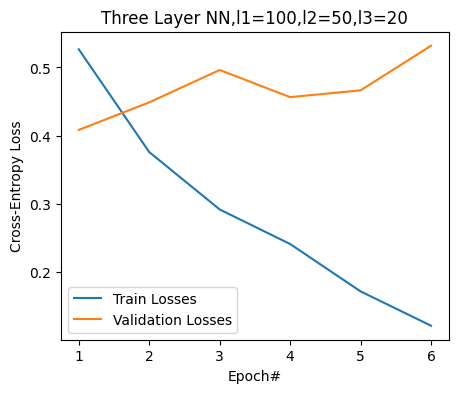

Number of correctly classified train samples=         832/1000
Number of correctly classified validation samples=         83/100


<Figure size 640x480 with 0 Axes>

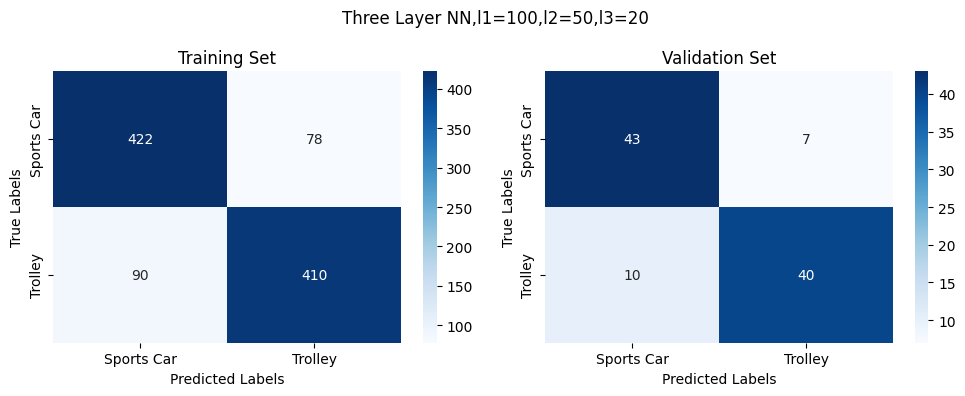

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.82      0.84      0.83       500
     Trolley       0.84      0.82      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.81      0.86      0.83        50
     Trolley       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



In [ ]:
threelayer = ThreeLayerNN()
run(threelayer)

### Four Layers

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.5526095480918884, Validation loss: 0.45923173427581787


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.4074072341918945, Validation loss: 0.45369935035705566


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.31138560056686404, Validation loss: 0.4437224864959717


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.24173531132936477, Validation loss: 0.448731392621994


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.17961503225564956, Validation loss: 0.6107208728790283


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.12220394107699394, Validation loss: 0.4473385214805603


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.10183027541637421, Validation loss: 0.6499184966087341


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.10174921868741513, Validation loss: 0.4903208911418915
Early stopping at epoch 8, using weights of epoch 3
Runtime=11.408531904220581


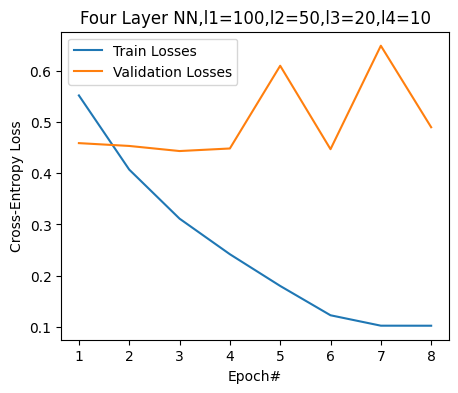

Number of correctly classified train samples=         925/1000
Number of correctly classified validation samples=         80/100


<Figure size 640x480 with 0 Axes>

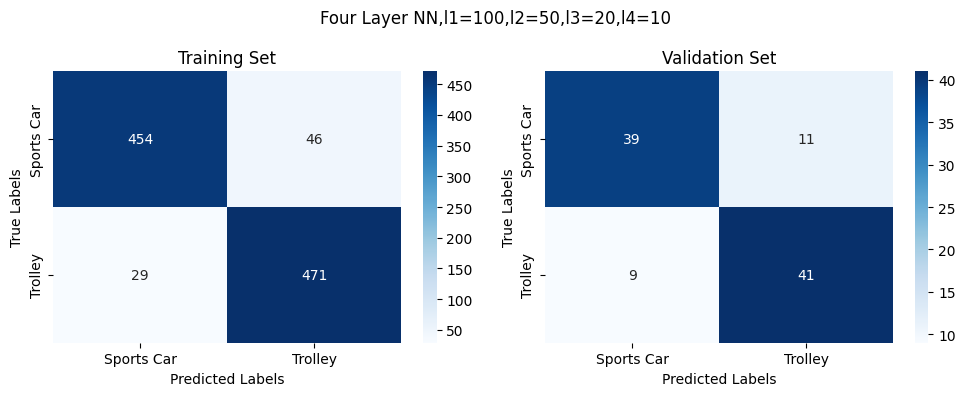

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.94      0.91      0.92       500
     Trolley       0.91      0.94      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.92      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.81      0.78      0.80        50
     Trolley       0.79      0.82      0.80        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



In [ ]:
fourlayer = FourLayerNN()
run(fourlayer)

## CNN

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.5695265693664551, Validation loss: 0.39102327823638916


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.40568239307403564, Validation loss: 0.38444221019744873


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.35717610120773313, Validation loss: 0.3190756142139435


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.30918263816833497, Validation loss: 0.3227943480014801


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.2900189464092255, Validation loss: 0.30001842975616455


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.22736766293644906, Validation loss: 0.2528340220451355


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.18124542832374574, Validation loss: 0.30706629157066345


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.16819898015260695, Validation loss: 0.2857884466648102


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.1298039538860321, Validation loss: 0.2590499818325043


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.07931535422801972, Validation loss: 0.38236004114151


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.06360459843277931, Validation loss: 0.3100106120109558
Early stopping at epoch 11, using weights of epoch 6
Runtime=43.706787109375


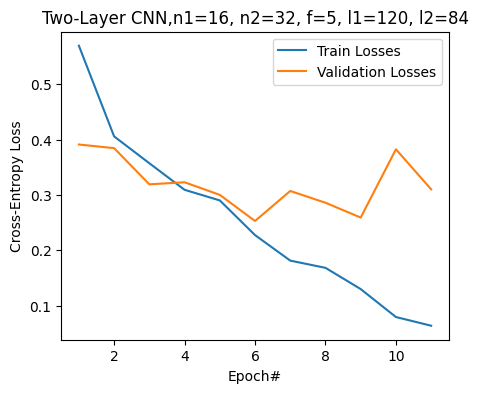

Number of correctly classified train samples=         923/1000
Number of correctly classified validation samples=         91/100


<Figure size 640x480 with 0 Axes>

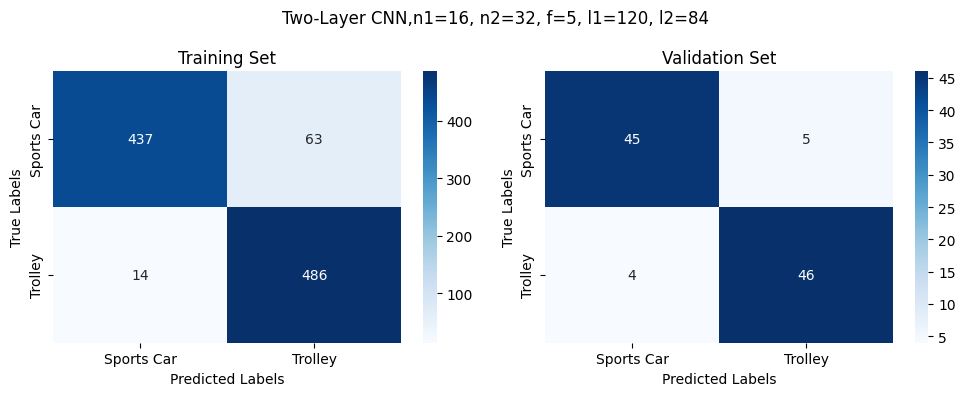

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.97      0.87      0.92       500
     Trolley       0.89      0.97      0.93       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.92      0.90      0.91        50
     Trolley       0.90      0.92      0.91        50

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [ ]:
cnnmodel_16_32 = TwoLayerCNN()
run(cnnmodel_16_32)

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.645051495552063, Validation loss: 0.562197744846344


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.48068741834163664, Validation loss: 0.4746168553829193


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.3811290373802185, Validation loss: 0.44304928183555603


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.3207176127433777, Validation loss: 0.355788916349411


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.29162058544158936, Validation loss: 0.34715354442596436


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.2877616114616394, Validation loss: 0.30732813477516174


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.23620824265480042, Validation loss: 0.19531823694705963


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.1951820771098137, Validation loss: 0.23886628448963165


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.1615342687368393, Validation loss: 0.2196854054927826


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.17208926689624787, Validation loss: 0.3583391606807709


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.15111301743984223, Validation loss: 0.20534326136112213


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/100 - Train loss: 0.13687031888961793, Validation loss: 0.31974536180496216
Early stopping at epoch 12, using weights of epoch 7
Runtime=96.90235042572021


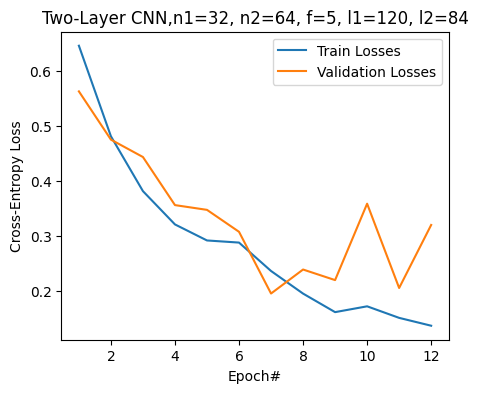

Number of correctly classified train samples=         933/1000
Number of correctly classified validation samples=         90/100


<Figure size 640x480 with 0 Axes>

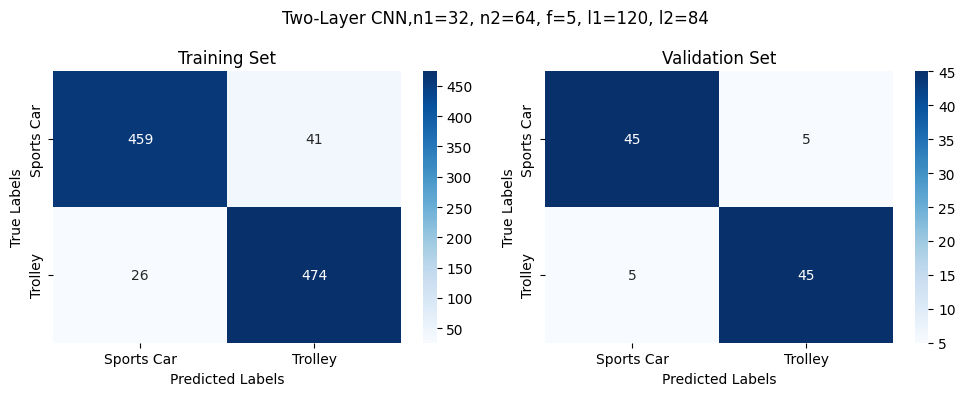

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.95      0.92      0.93       500
     Trolley       0.92      0.95      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.90      0.90      0.90        50
     Trolley       0.90      0.90      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [ ]:
cnnmodel_32_64 = TwoLayerCNN(n1=32, n2=64)
run(cnnmodel_32_64)

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.5755663673877716, Validation loss: 0.4316282272338867


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.423207004070282, Validation loss: 0.3600923418998718


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.39670415353775024, Validation loss: 0.3543553054332733


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.33748770523071286, Validation loss: 0.3503185212612152


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.33618494963645934, Validation loss: 0.3305119574069977


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.2941625299453735, Validation loss: 0.2580861747264862


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.2601041217446327, Validation loss: 0.3800472617149353


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.27160355091094973, Validation loss: 0.24729280173778534


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.19961580669879914, Validation loss: 0.317933052778244


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.20189010524749756, Validation loss: 0.2510349452495575


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.14838514086604118, Validation loss: 0.27702194452285767


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/100 - Train loss: 0.13436222657561303, Validation loss: 0.23681382834911346


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/100 - Train loss: 0.14953546345233917, Validation loss: 0.3607340157032013


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/100 - Train loss: 0.1256712581869215, Validation loss: 0.2609643340110779


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/100 - Train loss: 0.09232316678762435, Validation loss: 0.27288618683815


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/100 - Train loss: 0.08801931515336037, Validation loss: 0.2778751850128174


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/100 - Train loss: 0.061108851186931136, Validation loss: 0.2027277946472168


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/100 - Train loss: 0.048204569056630134, Validation loss: 0.4310258626937866


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/100 - Train loss: 0.03529424300044775, Validation loss: 0.3374110460281372


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/100 - Train loss: 0.08165767956525087, Validation loss: 0.5212600827217102


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/100 - Train loss: 0.08529811690142378, Validation loss: 0.3614411950111389


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/100 - Train loss: 0.05927107247523963, Validation loss: 0.5022936463356018
Early stopping at epoch 22, using weights of epoch 17
Runtime=99.49728274345398


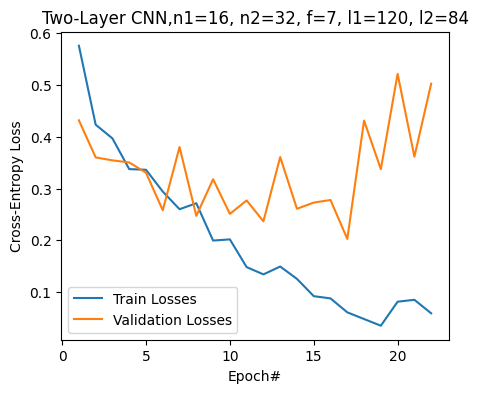

Number of correctly classified train samples=         994/1000
Number of correctly classified validation samples=         93/100


<Figure size 640x480 with 0 Axes>

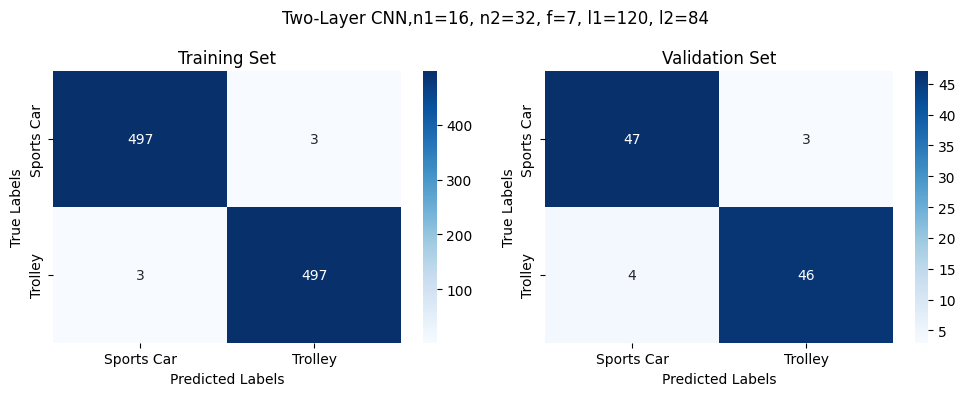

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.99      0.99      0.99       500
     Trolley       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.92      0.94      0.93        50
     Trolley       0.94      0.92      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [ ]:
cnnmodel_f_7 = TwoLayerCNN(f=7)
run(cnnmodel_f_7)

Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.5454977564811706, Validation loss: 0.4115581810474396


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.3614457380771637, Validation loss: 0.2821360230445862


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.26588497424125673, Validation loss: 0.30573520064353943


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.21626126658916472, Validation loss: 0.3086065649986267


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.16648428750038147, Validation loss: 0.25199148058891296


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.1380777871608734, Validation loss: 0.27236881852149963


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.06905738592892885, Validation loss: 0.3237459659576416


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.02628413715958595, Validation loss: 0.3622930943965912


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.02428618287295103, Validation loss: 0.4538534879684448


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.010757056541275232, Validation loss: 0.4617650508880615
Early stopping at epoch 10, using weights of epoch 5
Runtime=32.59408664703369


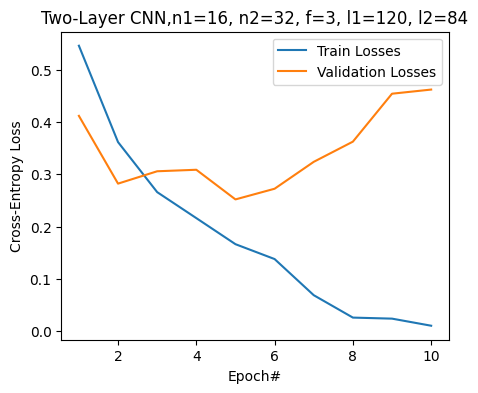

Number of correctly classified train samples=         957/1000
Number of correctly classified validation samples=         90/100


<Figure size 640x480 with 0 Axes>

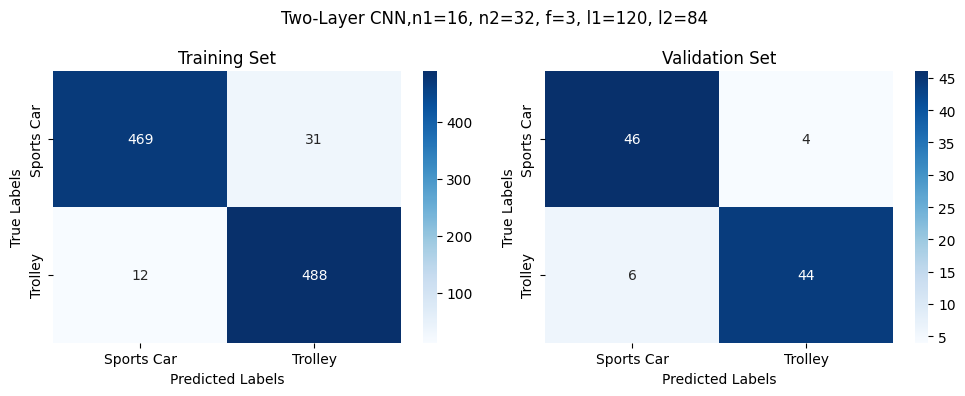

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.98      0.94      0.96       500
     Trolley       0.94      0.98      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.88      0.92      0.90        50
     Trolley       0.92      0.88      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [ ]:
cnnmodel_f_3 = TwoLayerCNN(f=3)
run(cnnmodel_f_3)

## Special Neural Nets

### ResNets

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.6317270736694336, Validation loss: 1.393998146057129


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.3096984992027283, Validation loss: 0.31759703159332275


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.15868248689174652, Validation loss: 0.4223363399505615


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.12873265239596368, Validation loss: 0.6729776263237


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.161973678201437, Validation loss: 0.3212880790233612


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.09982589501142501, Validation loss: 0.18380554020404816


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.05873607457056641, Validation loss: 1.1407874822616577


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.05252616722136736, Validation loss: 0.20030759274959564


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.04701449139416218, Validation loss: 0.3666861355304718


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.0286625951230526, Validation loss: 0.19541816413402557


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.12118499488756061, Validation loss: 0.3083687126636505
Early stopping at epoch 11, using weights of epoch 6
Runtime=318.0504186153412


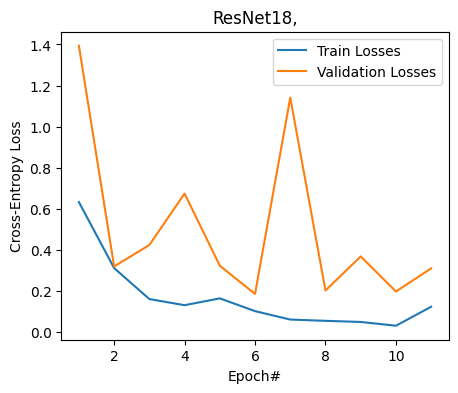

Number of correctly classified train samples=         992/1000
Number of correctly classified validation samples=         92/100


<Figure size 640x480 with 0 Axes>

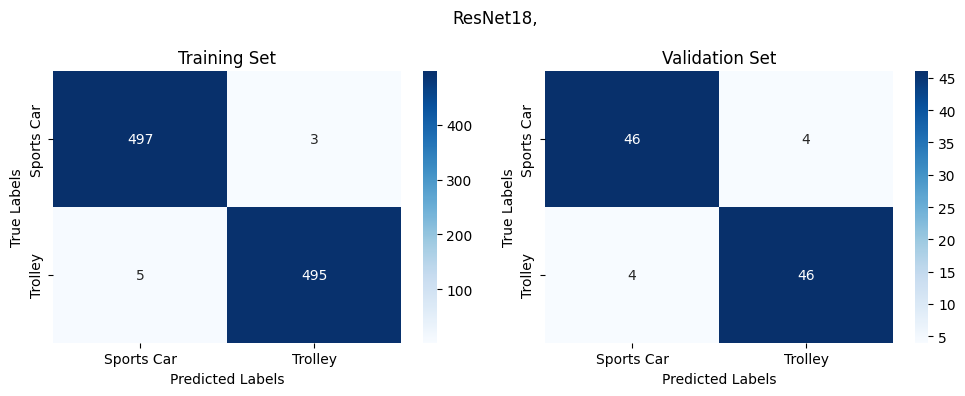

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.99      0.99      0.99       500
     Trolley       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.92      0.92      0.92        50
     Trolley       0.92      0.92      0.92        50

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



In [ ]:
resnet18 =ResNet18()
run(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 101MB/s]


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.6104607276916504, Validation loss: 0.4079166650772095


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.3150638027191162, Validation loss: 0.26307934522628784


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.2543492903709412, Validation loss: 0.25355270504951477


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.20087061858177185, Validation loss: 0.2157377004623413


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.15902789452672006, Validation loss: 0.3306548297405243


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.12782659956812858, Validation loss: 0.30671578645706177


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.06950770626962186, Validation loss: 0.3713306486606598


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.14912786889076232, Validation loss: 0.3707295358181


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.07877894973754883, Validation loss: 0.41369491815567017
Early stopping at epoch 9, using weights of epoch 4
Runtime=474.09319257736206


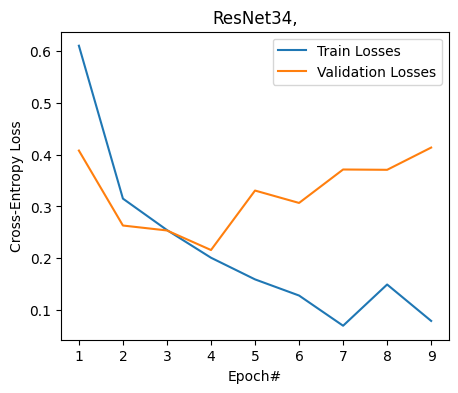

Number of correctly classified train samples=         982/1000
Number of correctly classified validation samples=         89/100


<Figure size 640x480 with 0 Axes>

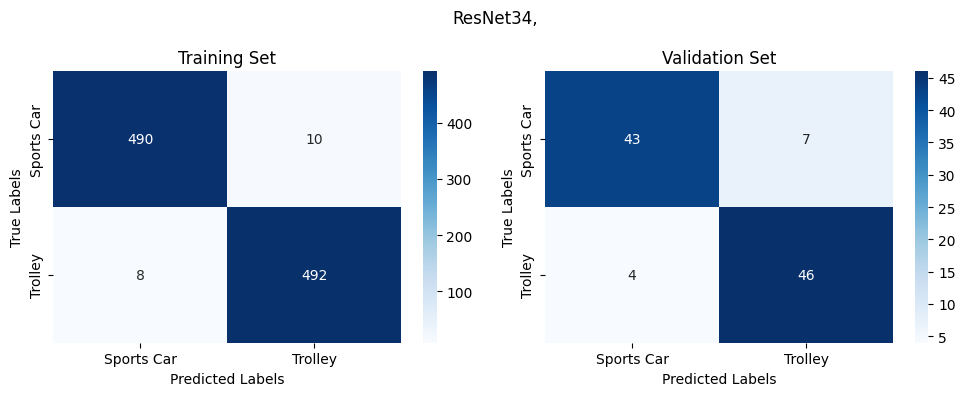

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.98      0.98      0.98       500
     Trolley       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.91      0.86      0.89        50
     Trolley       0.87      0.92      0.89        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [ ]:
resnet34 = ResNet34()
run(resnet34)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.5878784477710723, Validation loss: 2.4704062938690186


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.3264704518318176, Validation loss: 0.5611217021942139


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.1991799733042717, Validation loss: 0.369006872177124


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.1408079705759883, Validation loss: 0.2284628301858902


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.06995499243587255, Validation loss: 0.27129292488098145


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.15892024998366833, Validation loss: 0.19078770279884338


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.04694137108325958, Validation loss: 0.20758099853992462


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.08520300839841366, Validation loss: 0.8229526281356812


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.07654049788415432, Validation loss: 0.2497924566268921


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.06086093832924962, Validation loss: 0.5541761517524719


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.1067799138277769, Validation loss: 0.28849145770072937
Early stopping at epoch 11, using weights of epoch 6
Runtime=738.9911890029907


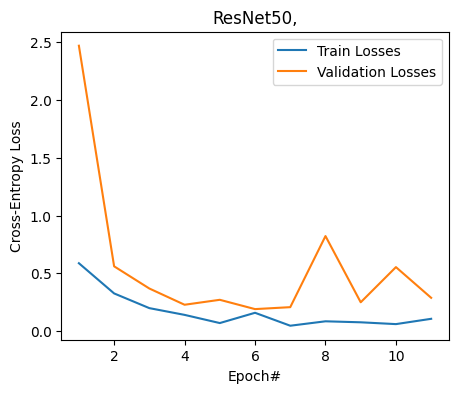

Number of correctly classified train samples=         982/1000
Number of correctly classified validation samples=         91/100


<Figure size 640x480 with 0 Axes>

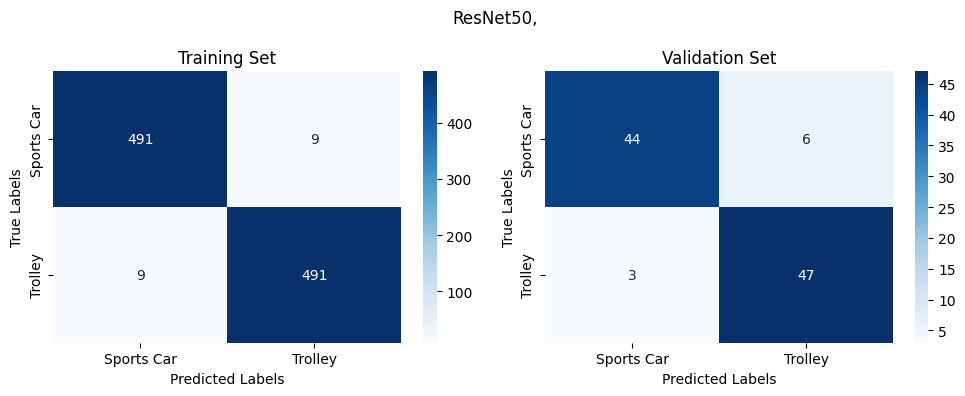

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       0.98      0.98      0.98       500
     Trolley       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       0.94      0.88      0.91        50
     Trolley       0.89      0.94      0.91        50

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [ ]:
resnet50 = ResNet50()
run(resnet50)

### VGG-16

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 94.0MB/s]


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.4175185850234702, Validation loss: 0.044600456953048706


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.22283063809294254, Validation loss: 0.026621853932738304


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.10656973255425692, Validation loss: 0.02755947783589363


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.0945311220958829, Validation loss: 0.030653541907668114


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.06832016696035861, Validation loss: 0.01638619229197502


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.07046986824646592, Validation loss: 0.05365347862243652


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.05120611086208373, Validation loss: 0.008331981487572193


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.061831037793308494, Validation loss: 0.007049170322716236


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.04483019440341741, Validation loss: 0.008589607663452625


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.033804257122799754, Validation loss: 0.004119285847991705


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.04840979452850297, Validation loss: 0.027553033083677292


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/100 - Train loss: 0.033191844007931647, Validation loss: 0.03216137737035751


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/100 - Train loss: 0.03492695494665531, Validation loss: 0.0017658922588452697


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/100 - Train loss: 0.031219206178328022, Validation loss: 0.03616300970315933


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/100 - Train loss: 0.032525573549877666, Validation loss: 0.0009747311705723405


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/100 - Train loss: 0.01848050938038068, Validation loss: 0.003117950167506933


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/100 - Train loss: 0.04169661529606674, Validation loss: 0.00104915676638484


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/100 - Train loss: 0.03196634111599997, Validation loss: 0.0005730640841647983


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/100 - Train loss: 0.02757730538211763, Validation loss: 0.004933276679366827


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/100 - Train loss: 0.016700424073147587, Validation loss: 0.0015646242536604404


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/100 - Train loss: 0.009132654896471621, Validation loss: 0.0017256722785532475


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/100 - Train loss: 0.011553573857177753, Validation loss: 0.0034442755859345198


Training loop:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/100 - Train loss: 0.010251468646339617, Validation loss: 0.024052660912275314
Early stopping at epoch 23, using weights of epoch 18
Runtime=1303.6146466732025


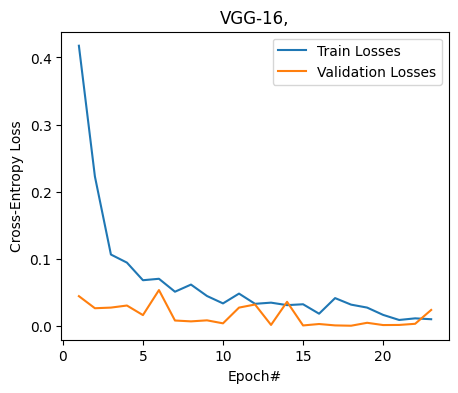

Number of correctly classified train samples=         1000/1000
Number of correctly classified validation samples=         100/100


<Figure size 640x480 with 0 Axes>

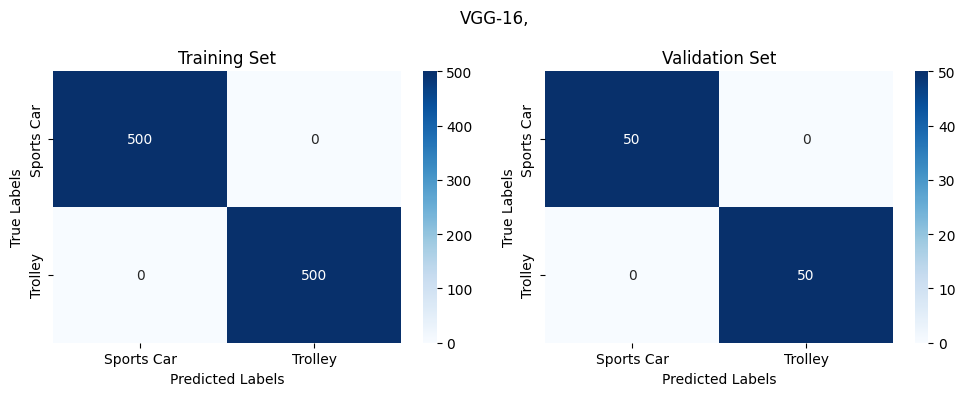

Classification Report for Train Set: 
               precision    recall  f1-score   support

  Sports Car       1.00      1.00      1.00       500
     Trolley       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Classification Report for Validation Set: 
               precision    recall  f1-score   support

  Sports Car       1.00      1.00      1.00        50
     Trolley       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:
vgg16 = VGG16()

run(vgg16)